In [1]:
import argparse
import torch
from utils_ccdm import get_model, LoadEncoder
from models.engine import DDIMSampler, DDIMSamplerEncoder, ConsisctencySampler
from models.ddpm_scheduler import NoiseScheduler 
from torchvision.utils import save_image, make_grid
from collections import OrderedDict
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import os
import gc

 accelerate launch --gpu_ids='all' train.py --arch unetic --data ./data/CelebA_train --img_size 128 --batch_size 24 --lr 6e-5 --num_condition 4 2 --epochs 30 --exp CelebA_128 --dir ddim_IC --eval_interval 2

In [2]:
from torchvision.transforms.functional import to_pil_image

In [3]:
CFG = CelebA()
CFG.OBJ2IDX

NameError: name 'CelebA' is not defined

In [4]:
class Args(argparse.Namespace):
    arch = "unetic"
    img_size=64
    num_timestep = 1000
    beta = (0.0001, 0.02)
    pretrained_nums_cond = [4, 2]
    emb_size = 128
    channel_mult = [1, 2, 2, 2]
    num_res_blocks = 2
    use_spatial_transformer = True
    num_heads = 4
    num_sample_missing = 1
    num_sample = 8
    w = 1.8
    projection_dim=512
    only_table = False
    concat = False
    only_encoder = False
    num_head_channels = -1
    encoder_path = None
    compose = False
    dataset = "CelebA_train"
    exp = "cd_GFemaleIC"
    time_cond_proj_dim = 128



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args_cd = Args()
args = Args

In [7]:
class Args(argparse.Namespace):
    arch = "unetic"
    img_size=64
    num_timestep = 1000
    beta = (0.0001, 0.02)
    pretrained_nums_cond = [4, 2]
    emb_size = 128
    channel_mult = [1, 2, 2, 2]
    num_res_blocks = 2
    use_spatial_transformer = True
    num_heads = 4
    num_sample_missing = 1
    num_sample = 8
    w = 1.8
    projection_dim=512
    only_table = False
    concat = False
    only_encoder = False
    num_head_channels = -1
    encoder_path = None
    compose = False
    dataset = "CelebA_train"
    exp = "ddim_IC"
    time_cond_proj_dim = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args_ddim = Args()

### CD model loading

In [34]:
model_cd = get_model(args_cd, args_cd.time_cond_proj_dim)

# ckpt_cd = torch.load(os.path.join("checkpoints", args_cd.dataset, args_cd.exp, "target_unet.pth"))["model"]
ckpt_cd = torch.load("checkpoints/CelebA_cd/adaptive_GF/unet_19.pth")["model"]
#ckpt_cd = torch.load("checkpoints/CelebA_cd/GFemaleIC/target_unet.pth")["model"]

new_ckpt_cd = OrderedDict()
    
for k, v in ckpt_cd.items():
    #print(k)
    if k.startswith("module"):
        new_ckpt_cd[k[7:]] = v
    else:
        new_ckpt_cd[k] = v
        
#print(new_dict)

missing_keys, unexpected_keys = model_cd.load_state_dict(new_ckpt_cd, strict=False)
print("Missing keys:", missing_keys)
print("Unexpected keys:", unexpected_keys)
        
for p in model_cd.parameters():
    p.requires_grad = False

model_cd.eval()
model_cd.to(device)

Missing keys: []
Unexpected keys: []


UNetIC(
  (time_embedding): TimeEmbedding(
    (cond_proj): Linear(in_features=128, out_features=128, bias=False)
    (emb_layer): Embedding(1000, 128)
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
    (act): Swish()
  )
  (atr_embedding): ConditionalEmbedding(
    (embedding_table): Embedding(5, 128)
    (emb): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Swish()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (obj_embedding): ConditionalEmbedding(
    (embedding_table): Embedding(3, 128)
    (emb): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Swish()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (head): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downblocks): ModuleList(
    (0): ResBlockImageClassConcat(
      (block1): Sequenti

### DDIM model loading

In [11]:
model_ddim = get_model(args_ddim)

# ckpt_ddim = torch.load(os.path.join("checkpoints", args_ddim.dataset, "mnist5x10x64_ic.pth"), map_location='cpu')["model"]
# ckpt_ddim = torch.load(r"checkpoints/colored_mnist/mnist5x10x64_ic.pth",map_location='cpu')["model"]
ckpt_ddim = torch.load("checkpoints/CelebA_cd/GFemaleIC/teacher_IC.pth")["model"]

new_ckpt_ddim = OrderedDict()
    
for k, v in ckpt_ddim.items():
    #print(k)
    if k.startswith("module"):
        new_ckpt_ddim[k[7:]] = v
    else:
        new_ckpt_ddim[k] = v
        
#print(new_dict)

missing_keys, unexpected_keys = model_ddim.load_state_dict(new_ckpt_ddim, strict=False)
print("Missing keys:", missing_keys)
print("Unexpected keys:", unexpected_keys)

# Manually assign weights for special cases
for i in range(len(missing_keys)):
    assert missing_keys[i].split(".")[-1] == unexpected_keys[i].split(".")[-1]
    model_ddim.state_dict()[missing_keys[i]].copy_(new_ckpt_ddim[unexpected_keys[i]])
    
for p in model_ddim.parameters():
    p.requires_grad = False

model_ddim.eval()
model_ddim.to(device)

Missing keys: ['time_embedding.emb_layer.weight', 'time_embedding.linear_1.weight', 'time_embedding.linear_1.bias', 'time_embedding.linear_2.weight', 'time_embedding.linear_2.bias']
Unexpected keys: ['time_embedding.timembedding.0.weight', 'time_embedding.timembedding.1.weight', 'time_embedding.timembedding.1.bias', 'time_embedding.timembedding.3.weight', 'time_embedding.timembedding.3.bias']


UNetIC(
  (time_embedding): TimeEmbedding(
    (emb_layer): Embedding(1000, 128)
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
    (act): Swish()
  )
  (atr_embedding): ConditionalEmbedding(
    (embedding_table): Embedding(5, 128)
    (emb): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Swish()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (obj_embedding): ConditionalEmbedding(
    (embedding_table): Embedding(3, 128)
    (emb): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Swish()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (head): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downblocks): ModuleList(
    (0): ResBlockImageClassConcat(
      (block1): Sequential(
        (0): GroupNorm(32, 128, eps=1e-05, affine=True)
        (1)

In [9]:
noise_scheduler = NoiseScheduler()
CFG = None

### sampling func for CD

In [13]:
def cd_eval(model, noise_scheduler, args, CFG=None ,num_inference_steps=4, n_samples=1 ,device=device):
    num_atr, num_obj = args.pretrained_nums_cond[0], args.pretrained_nums_cond[1]
    n_samples =  num_atr * num_obj * n_samples

    sampler = ConsisctencySampler(model, noise_scheduler, n_samples, args, device=device)    

    # create conditions of each class
    # create conditions like [0,0,0,1,1,1, ...] [0,1,2,3,0,1,2,3, ...]
    c1 = torch.arange(0, num_atr)
    c2 = torch.arange(0, num_obj)
    c1 = c1.repeat(n_samples // num_atr, 1).permute(1, 0).reshape(-1)
    c2 = c2.repeat(n_samples // num_obj)
    c1, c2 = c1.to(device), c2.to(device)

    # create noise
    x_t = torch.randn(n_samples, 3, args.img_size, args.img_size).to(device=device, dtype=torch.float32)

    images = sampler(
                c1, 
                c2,
                x_t = x_t, 
                num_inference_steps = num_inference_steps,
                guidance_scale = args.w + 1 ,
             )

    # save image
    # os.makedirs(os.path.join('result', args.exp, args.save_path), exist_ok=True)
    # save_image(images, os.path.join('result', args.exp, args.save_path, f'epoch_{epoch}.png'))
    
            
    # log image
#     images = images.permute(0, 2, 3, 1)
#     images = images.cpu().detach().numpy()
#     c1, c2 = c1.cpu().detach().numpy(), c2.cpu().detach().numpy()
    
#     images = [(f"{CFG.IDX2ATR[c1[i]]} {CFG.IDX2OBJ[c2[i]]}", images[i, :, :, :]) for i in range(n_samples)]
    # accelerator.log({f"{name} model eval": [wandb.Image(img, caption=label) for label, img in images]})

    del sampler
    gc.collect()
    torch.cuda.empty_cache()

    return images

In [14]:
def ddim_eval(model_ddim, args, device=device, num_inference_steps=4, n_samples=1):
    
    sampler = DDIMSampler(
        model=model_ddim,
        beta =args.beta,
        T=args.num_timestep,
        w=args.w,
    ).to(device)

    num_atr, num_obj = args.pretrained_nums_cond[0], args.pretrained_nums_cond[1]
    n_samples_ = num_atr * num_obj * n_samples

    c1s = torch.arange(0, num_atr)
    c2s = torch.arange(0, num_obj)
    c1s = c1s.repeat(n_samples_ // num_atr, 1).permute(1, 0).reshape(-1)
    c2s = c2s.repeat(n_samples_ // num_obj)
    c1s, c2s = c1s.to(device), c2s.to(device)
    
    x_t = torch.randn(n_samples_, 3, args.img_size, args.img_size).to(device=device, dtype=torch.float32)

    imgs = sampler(
                x_t,
                c1s.to(dtype=torch.long), 
                c2s.to(dtype=torch.long),
                steps=num_inference_steps,
             )
    imgs_processed = ((imgs + 1) / 2).clamp(0, 1)

        
    del sampler
    gc.collect()
    torch.cuda.empty_cache()

    return imgs_processed  

## consistency distillation eval result
### CelebA adaptive cd 64

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.92it/s]


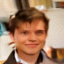

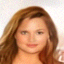

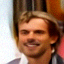

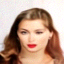

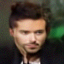

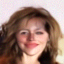

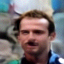

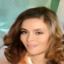

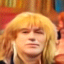

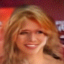

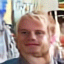

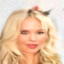

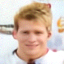

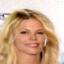

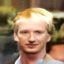

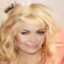

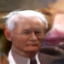

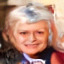

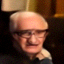

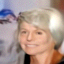

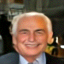

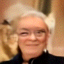

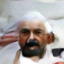

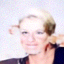

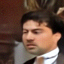

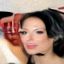

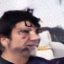

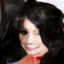

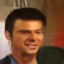

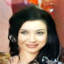

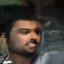

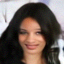

In [35]:
imgs = cd_eval(model_cd, noise_scheduler, args_cd, num_inference_steps=2, n_samples=4)
for img in imgs:
    display(to_pil_image(img))

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.93it/s]


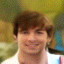

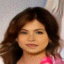

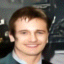

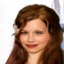

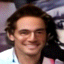

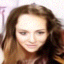

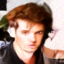

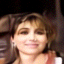

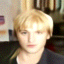

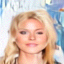

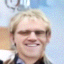

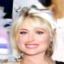

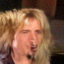

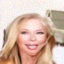

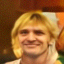

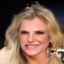

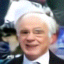

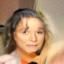

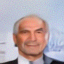

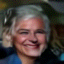

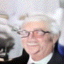

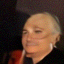

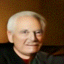

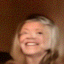

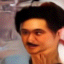

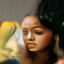

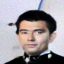

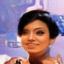

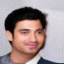

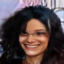

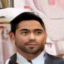

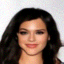

In [36]:
imgs = cd_eval(model_cd, noise_scheduler, args_cd, num_inference_steps=3, n_samples=4)
for img in imgs:
    display(to_pil_image(img))

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


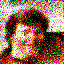

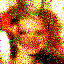

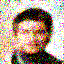

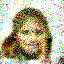

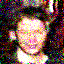

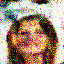

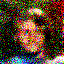

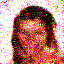

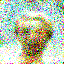

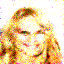

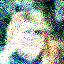

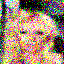

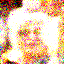

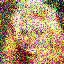

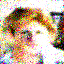

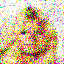

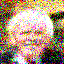

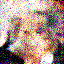

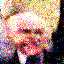

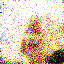

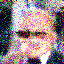

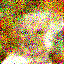

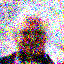

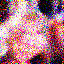

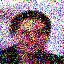

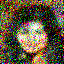

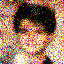

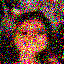

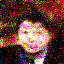

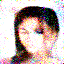

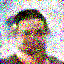

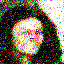

In [37]:
imgs = cd_eval(model_cd, noise_scheduler, args_cd, num_inference_steps=1, n_samples=4)
for img in imgs:
    display(to_pil_image(img))

### CelebA 64 original cd

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.91it/s]


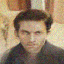

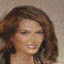

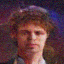

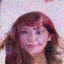

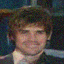

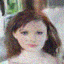

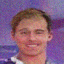

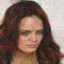

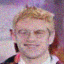

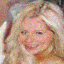

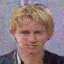

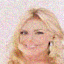

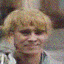

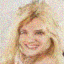

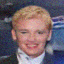

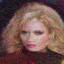

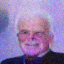

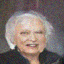

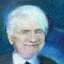

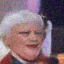

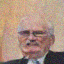

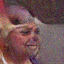

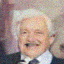

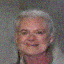

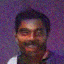

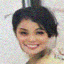

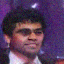

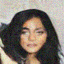

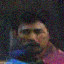

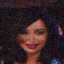

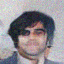

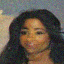

In [28]:
imgs = cd_eval(model_cd, noise_scheduler, args_cd, num_inference_steps=2, n_samples=4)
for img in imgs:
    display(to_pil_image(img))

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.94it/s]


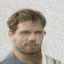

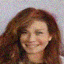

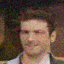

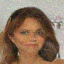

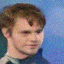

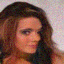

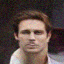

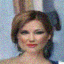

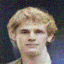

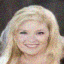

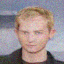

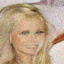

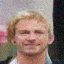

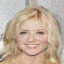

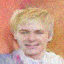

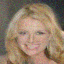

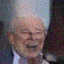

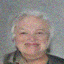

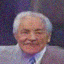

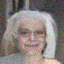

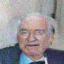

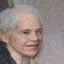

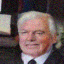

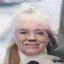

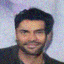

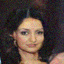

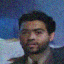

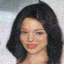

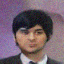

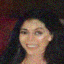

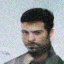

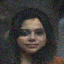

In [29]:
imgs = cd_eval(model_cd, noise_scheduler, args_cd, num_inference_steps=3, n_samples=4)
for img in imgs:
    display(to_pil_image(img))

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.89it/s]


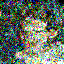

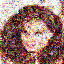

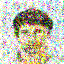

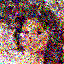

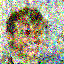

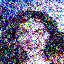

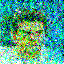

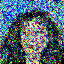

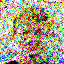

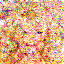

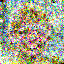

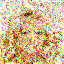

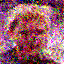

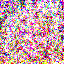

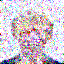

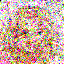

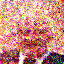

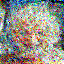

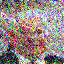

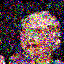

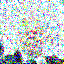

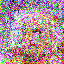

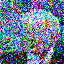

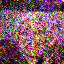

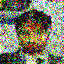

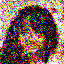

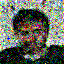

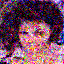

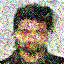

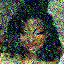

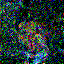

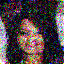

In [33]:
imgs = cd_eval(model_cd, noise_scheduler, args_cd, num_inference_steps=1, n_samples=4)
for img in imgs:
    display(to_pil_image(img))

## DDIM (baseline) Eval results
### CelebA 64

100%|███████████████████████████| 2/2 [00:00<00:00,  7.50it/s, step=1, sample=1]


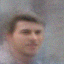

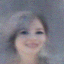

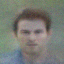

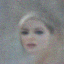

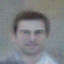

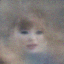

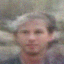

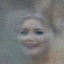

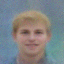

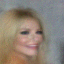

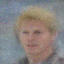

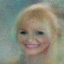

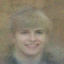

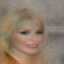

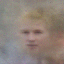

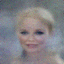

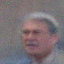

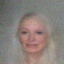

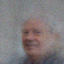

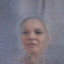

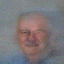

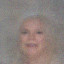

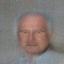

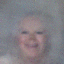

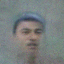

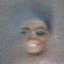

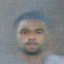

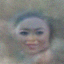

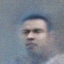

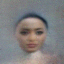

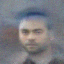

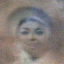

In [30]:
imgs = ddim_eval(model_ddim, args_ddim, num_inference_steps=2, n_samples=4)
for img in imgs:
    display(to_pil_image(img.squeeze()))


### CelebA

100%|███████████████████████████| 3/3 [00:00<00:00,  6.98it/s, step=1, sample=1]


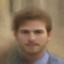

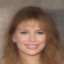

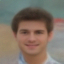

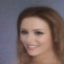

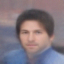

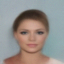

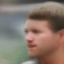

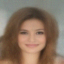

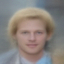

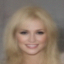

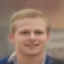

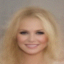

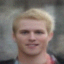

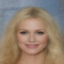

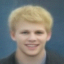

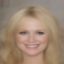

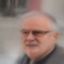

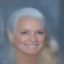

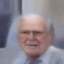

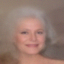

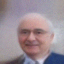

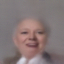

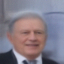

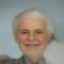

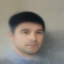

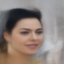

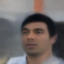

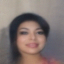

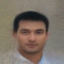

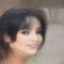

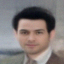

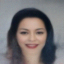

In [31]:
imgs = ddim_eval(model_ddim, args_ddim, num_inference_steps=3, n_samples=4)
for img in imgs:
    display(to_pil_image(img.squeeze()))

100%|███████████████████████████| 1/1 [00:00<00:00,  9.86it/s, step=1, sample=1]


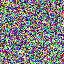

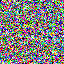

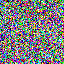

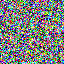

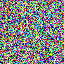

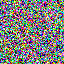

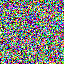

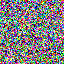

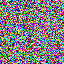

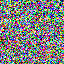

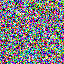

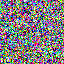

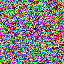

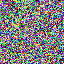

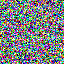

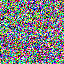

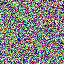

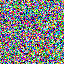

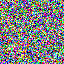

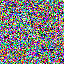

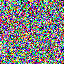

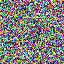

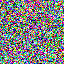

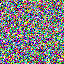

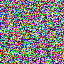

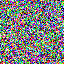

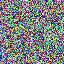

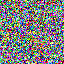

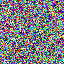

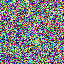

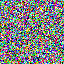

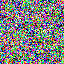

In [32]:
imgs = ddim_eval(model_ddim, args_ddim, num_inference_steps=1, n_samples=4)
for img in imgs:
    display(to_pil_image(img.squeeze()))

In [5]:
from config import *

if args.dataset == "Zappo50K":
    CFG = Zappo50K()
elif args.dataset == "CelebA":
    CFG = CelebA()
elif args.dataset == "Colored_Mnist_5x10":
    CFG = Colored_MNIST()
else:
    CFG = toy_dataset()
# CFG = Zappo50K()
# missing = "Heel Slipper"
# targets = ["Flat Boot", "Flat Shoe", "Flat Slipper", "Flat Sandal", "Heel Boot", "Heel Shoe", "Heel Sandal"]
targets = ["bw_1","red_1","blu_2","ylw_2",
           "red_3","bw_3","grn_4","ylw_4",
           "grn_5","blu_5","red_6","grn_6",
           "blu_7","grn_7","red_8","bw_8",
           "bw_9","ylw_9","blu_0","ylw_0",]
#targets = ["Brown_Hair Male", "Black_Hair Male", "Gray_Hair Male", "Blond_Hair Male", "Brown_Hair Female", "Black_Hair Female", "Blond_Hair Female"]

epsilon = 0

In [ ]:
# sampler = DDPMSamplerOneCond(
#    model,
#    beta=args.beta,
#    T=args.num_timestep,
#    w=args.w,
# )

sampler = DDIMSampler(
    model=model_ddim,
    beta =args_ddim.beta,
    T=args_ddim.num_timestep,
    w=args_ddim.w,
).to(device)

# if args.encoder_path != None:
#     encoder = LoadEncoder(args).to(device)
#     sampler = DDIMSamplerEncoder(
#             model = model,
#             encoder = encoder,
#             beta = args.beta,
#             T = args.num_timestep,
#             w = args.w,
#             only_encoder = args.only_encoder
#     ).to(device)

100%|██████████| 20/20 [00:00<00:00, 27.66it/s, step=1, sample=1]


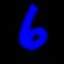

100%|██████████| 20/20 [00:00<00:00, 27.06it/s, step=1, sample=1]


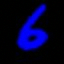

100%|██████████| 20/20 [00:00<00:00, 27.46it/s, step=1, sample=1]


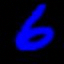

100%|██████████| 20/20 [00:00<00:00, 27.95it/s, step=1, sample=1]


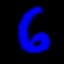

100%|██████████| 20/20 [00:00<00:00, 26.44it/s, step=1, sample=1]


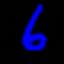

100%|██████████| 20/20 [00:00<00:00, 27.70it/s, step=1, sample=1]


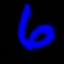

100%|██████████| 20/20 [00:00<00:00, 27.10it/s, step=1, sample=1]


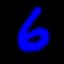

100%|██████████| 20/20 [00:00<00:00, 28.48it/s, step=1, sample=1]


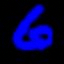

100%|██████████| 20/20 [00:00<00:00, 29.25it/s, step=1, sample=1]


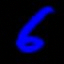

100%|██████████| 20/20 [00:00<00:00, 27.18it/s, step=1, sample=1]


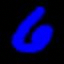

In [103]:
tgt = "blu_6"
atr, obj = CFG.ATR2IDX[tgt.split("_")[0]], CFG.OBJ2IDX[tgt.split("_")[-1]]
sample_batch = 1
# atr = torch.tensor(atr, dtype=torch.long, device=device).repeat(sample_batch)
# obj = torch.tensor(obj, dtype=torch.long, device=device).repeat(sample_batch)
atr = torch.tensor(atr, device=device).repeat(sample_batch)
obj = torch.tensor(obj, device=device).repeat(sample_batch)
# for j in range(args.num_sample_missing // sample_batch):
for j in range(10):
    x_i = torch.randn(1, 3, 64, 64).to(device)
    # t = torch.full((x_i.shape[0],), 100, dtype=torch.long, device=device) 
    x0 = sampler(x_i, atr, obj, steps=20).squeeze(0)
    #save_image(x0, f'grn{j}.png')
    x0_processed = ((x0 + 1) / 2).clamp(0, 1)
#     print((x0 + 1) / 2)
#     print(x0_processed)
    display(to_pil_image(x0_processed))


In [60]:
# for j in range(args.num_sample_missing // sample_batch):
#     x_i = torch.randn(sample_batch, 3, 64, 64).to(device)
#     t = torch.full((x_i.shape[0],), 100, dtype=torch.long, device=device) 
    
#     x0 = sampler(x_i, atr, obj, steps=100).squeeze(0)
#     epsilon = model(x_i, t, atr, obj)
#     i = j * sample_batch
#     os.makedirs(os.path.join("SampledImg/ShapeColor/DualCond", args.exp), exist_ok=True)
#     for x in x0:
#         save_image(x, os.path.join("SampledImg/ShapeColor/DualCond", args.exp, "{:05d}.jpg".format(i)))
#         i += 1
# save_image(x0, "SampledImg/DualCond/GrayFemaleAdaGN.png", nrow=10, noramlized=True)

images = []
steps = 4
for target in targets:
    atr, obj = CFG.ATR2IDX[target.split("_")[0]], CFG.OBJ2IDX[target.split("_")[-1]]
    atr = torch.tensor(atr, dtype=torch.long, device=device).repeat(args.num_sample)
    obj = torch.tensor(obj, dtype=torch.long, device=device).repeat(args.num_sample)

    x_i = torch.randn(args.num_sample, 3, 64, 64).to(device)
    x0 = sampler(x_i, atr, obj, steps=steps)
    x0_processed = ((x0 + 1) / 2).clamp(0, 1)
    images.append(x0)
images = torch.concatenate(images, dim=0)
save_image(images, f"colored_mnist_{steps}.png", nrow=args.num_sample, normalized=True)

In [12]:
def _image_grid(imgs, rows, cols):
        """
        input -
        1. imgs - np array dims num_images x **(image_dims)
        2. rows, cols - number of rows and columns in the image grid
        output - 
        1. saved image grid on the disk at the end when all the images are pasted after multiple iterations
        """
        n,c,w,h = imgs.shape

        grid = Image.new('RGB', size=(cols*w, rows*h))
        
        if isinstance(imgs, torch.Tensor):
            imgs = imgs.cpu().numpy()

        grid_w, grid_h = grid.size
        for idx in range(n):
            img = imgs[idx,:].squeeze()
            img = Image.fromarray(img)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            grid.paste(img, box=(idx*w, 0))
        return grid

In [14]:
print("{:04d}".format(1))

0001


In [59]:
from glob import glob
import os
import random
import shutil

data_root = "data/CelebA"
train_root = "data/CelebA_train"
val_root = "data/CelebA_val"
os.makedirs(train_root, exist_ok=True)
os.makedirs(val_root, exist_ok=True)

for target in os.listdir(data_root):
    os.makedirs(os.path.join(train_root, target), exist_ok=True)
    images = glob(os.path.join(data_root, target, "*.jpg"))
    train_imgs = random.sample(images, int(0.8 * len(images)))
    for img in train_imgs:
        name = img.split("/")[-1]
        shutil.move(img, os.path.join(train_root, target, name))
    print(target, len(train_imgs))


Gray_Hair Female 1011
Black_Hair Female 18652
Brown_Hair Male 10230
Blond_Hair Male 1399
Blond_Hair Female 22587
Gray_Hair Male 5788
Black_Hair Male 20124
Brown_Hair Female 23027


In [60]:
for target in os.listdir(data_root):
    os.makedirs(os.path.join(val_root, target), exist_ok=True)
    images = glob(os.path.join(data_root, target, "*.jpg"))
    for img in images:
        name = img.split("/")[-1]
        shutil.move(img, os.path.join(val_root, target, name))
    print(target, len(images))

Gray_Hair Female 253
Black_Hair Female 4664
Brown_Hair Male 2558
Blond_Hair Male 350
Blond_Hair Female 5647
Gray_Hair Male 1447
Black_Hair Male 5032
Brown_Hair Female 5757


In [41]:
import cv2
import numpy as np

img = cv2.imread("/root/notebooks/nfs/work/dataset/CelebA/Black_Hair Male/021093.jpg")
# img = cv2.cvtColor(img, COLOR_BGR2GRAY)
gaussian = np.random.normal(0, 1, img.shape).astype(np.uint8)
img_t1 = 0.6 * img + 0.4 * gaussian
img_t = 0.3 * img + 0.7 * gaussian
# img_t1 = cv2.add(img, gaussian)
# img_t = cv2.add(img_t1, gaussian)
cv2.imwrite("x_t.jpg", img_t)
cv2.imwrite("Noise.jpg", gaussian)
cv2.imwrite("x_t1.jpg", img_t1)
cv2.imwrite("x0.jpg", img)

True